# Imports

In [13]:
import numpy as np
import pickle
import os.path
from os.path import isfile, join
from os import path,listdir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools


In [20]:
def add_data(df, date):
    Stimuli_Names = ['Left','Right','Back','Front','None']

    mypath = '/Volumes/BigFishThry/OMR/'+date
    fishies = [f for f in listdir(mypath) if '2022' in f]
    for fish in fishies:
        with open('/Volumes/BigFishThry/OMR/'+date+fish+'/experiment_information.txt', "r") as file1:
            Lines = file1.readlines() 
            
        DT = Lines[2].split(' ')[-1][:-1]
        unique_id = DT + '_'+ Lines[4].split(' ')[-1][:-1]
        FishAge = Lines[5].split(' ')[-1][:-1]
        FishCondition = Lines[6].split(' ')[-1][:-1]

        mypath = '/Volumes/BigFishThry/OMR/'+date+fish+'/raw_data'
        print(mypath)
        AllTrials = [f for f in listdir(mypath) if isfile(join(mypath, f))]

        for trial in AllTrials:
            with open(mypath+'/'+trial, "rb") as input_file:
                e = pickle.load(input_file)
            stimuli = [k for k in e.keys() if 'bouts_start_stimulus' in k]
            for stimulus in stimuli:

                indices_of_stimuli = np.logical_and(e[stimulus]['timestamp']>5, e[stimulus]['timestamp']< 15)
                radii = np.sqrt(e[stimulus]['fish_position_x']**2+e[stimulus]['fish_position_y']**2)<0.81
                no_error = np.logical_and(e[stimulus]['errorcode']==0,e['bouts_end_stimulus_'+stimulus[-3:]]['errorcode']==0)
                which_indices = np.logical_and(np.logical_and(indices_of_stimuli,radii),no_error)
                Changes_during_stimuli = e[stimulus]['fish_accumulated_orientation'][which_indices] - e['bouts_end_stimulus_'+stimulus[-3:]]['fish_accumulated_orientation'][which_indices]

                Changes_during_stimuli[Changes_during_stimuli>180] = Changes_during_stimuli[Changes_during_stimuli>180]-360
                Changes_during_stimuli[Changes_during_stimuli<-180] = Changes_during_stimuli[Changes_during_stimuli<-180]+360

                df_temp = pd.DataFrame({
                    'TrialNum': [int(trial[5:8])]*len(Changes_during_stimuli),
                    'Age': [FishAge]*len(Changes_during_stimuli), 
                    'Condition': [FishCondition]*len(Changes_during_stimuli), 
                    'Date': [date]*len(Changes_during_stimuli), 
                    'Stimulus':[Stimuli_Names[int(stimulus[-1])]]*len(Changes_during_stimuli), 
                    'OrientationChange':Changes_during_stimuli,
                    'FishID':[unique_id]*len(Changes_during_stimuli)
                    })
                df = df.append(df_temp)
    return df

In [14]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [15]:
def plot_Dist(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):
    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.histplot(data = Day_Data.query("Stimulus == 'Left'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.histplot(data = Day_Data.query("Stimulus == 'Right'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.histplot(data = Day_Data.query("Stimulus == 'Front'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.histplot(data = Day_Data.query("Stimulus == 'Back'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.histplot(data = Day_Data.query("Stimulus == 'None'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.title('None')

    plt.show()

In [16]:
def get_CummulativeAngle(input_df):
    Cumm_turns = np.zeros((len(np.unique(input_df['FishID'])),30))

    Fishies = list(np.unique(input_df['FishID']))

    for fishcount, fish in enumerate(Fishies):
        numTrials = len(np.unique(input_df.query("FishID == '" + fish+"'")['TrialNum']))
        for trial in np.unique(input_df.query("FishID == '" + fish+"'")['TrialNum']):
            Changes = input_df.query("FishID == '" + fish+"'").query("TrialNum == " + str(trial))['OrientationChange']
            Cumm_turns[fishcount,trial] = Changes.sum()
    return Cumm_turns

def plot_CummulativeAngle(Data, legend_on=True):     
        
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(1,2,1)
    LeftData = get_CummulativeAngle(Data.query("Stimulus == 'Left'"))
    sns.heatmap(LeftData[np.argsort(LeftData.sum(axis=1)),:],square=True, linewidths=.5, cbar_kws={"shrink": .5},cmap = cmap,center = 0)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(1,2,2)
    RightData = get_CummulativeAngle(Data.query("Stimulus == 'Right'"))
    sns.heatmap(RightData[np.argsort(RightData.sum(axis=1))[::-1],:],square=True, linewidths=.5, cbar_kws={"shrink": .5},cmap = cmap,center = 0)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.show()

In [5]:
def get_NumTurns(input_df,What_To_Plot):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            stats.append(float(len(Changes)))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df

def plot_NumTurns(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Left'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Right'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Front'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Back'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'None'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('None')

    plt.show()

In [6]:
def get_turn_stats(input_df,What_To_Plot):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            stats.append(np.sum(np.abs(Changes)<45)/len(Changes))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df

def plot_Prob(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Left'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Right'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Front'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Back'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'None'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('None')

    plt.show()

def get_Error_stats(input_df,What_To_Plot,stimuli):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            if stimuli == 'Left':
                stats.append(np.sum(Changes>15)/len(Changes))
            if stimuli == 'Right':
                stats.append(np.sum(Changes<-15)/len(Changes))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df


def Plot_Errors(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    sns.violinplot(data = get_Error_stats(Day_Data.query("Stimulus == 'Left'"),What_To_Plot,'Left'), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.ylabel('Prob Error')
    plt.title('Left')

    plt.subplot(1,2,2)
    sns.violinplot(data = get_Error_stats(Day_Data.query("Stimulus == 'Right'"),What_To_Plot,'Right'), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    
    plt.show()

In [23]:
OMR_Runs = pd.read_pickle("JointRuns2.pkl")


In [33]:
OMR_Runs.groupby('Condition').nunique('FishID')

,TrialNum,Age,FishID,Date,Stimulus,OrientationChange
Condition,,,,,,
23Tri,30,1,16,1,5,6171
23tri,30,1,32,1,5,7489
23tri_1hr,29,1,8,1,5,1101
dark,30,1,103,5,5,128020
dark-L,30,1,46,3,5,64703
strobe,30,1,96,5,5,129518
strobe-L,30,1,96,4,5,130178
tri_2to3,30,1,32,1,5,39094
tri_2to4,30,1,135,3,5,86183


# Silenced

In [12]:
z

,FishID,Stimulus,Condition,Age,Date,TrialNum,OrientationChange,BoutFrequency
0,2021-01-26_10-12-17_316,Front,Control,6,2021_01_26/,264.0,264.0,0.880000
1,2021-01-26_10-12-17_316,None,Control,6,2021_01_26/,43.0,43.0,0.143333
2,2021-01-26_10-12-17_317,Front,Control,6,2021_01_26/,169.0,169.0,0.563333
3,2021-01-26_10-12-17_317,None,Control,6,2021_01_26/,105.0,105.0,0.350000
4,2021-01-26_10-12-18_318,Front,Control,6,2021_01_26/,94.0,94.0,0.313333
...,...,...,...,...,...,...,...,...
1233,2021-11-10_21-10-22_1942,Front,6-7,6,2021_11_10/,372.0,372.0,1.240000
1234,2021-11-10_21-10-22_1942,None,6-7,6,2021_11_10/,38.0,38.0,0.126667
1235,2021-11-10_21-10-22_1943,Front,6-7,6,2021_11_10/,20.0,20.0,0.066667
0,one,Front,0,6,none,NaN,NaN,NaN


<Axes.ArtistList of 0 artists>

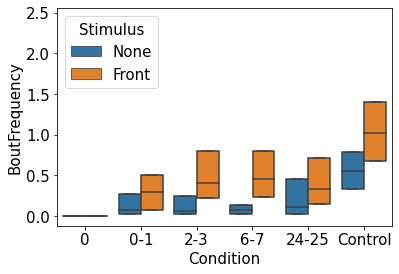

In [128]:
ax = sns.boxplot(x = 'Condition', hue = 'Stimulus', y = 'BoutFrequency', fliersize=0, whis = 0, data = z, hue_order = ['None','Front'], order = ['0','0-1','2-3','6-7','24-25','Control'])

ax.artists

/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_1956/2690038075.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


Front None , pval: 5.961457924230754e-45


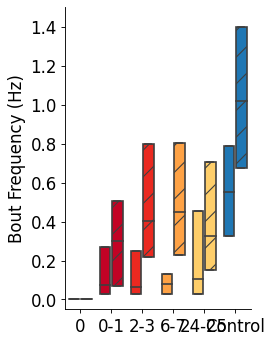

In [168]:
fig = plt.figure(figsize=(3, 5), dpi=80)

data = OMR_Runs[(OMR_Runs.Stimulus == 'None')| (OMR_Runs.Stimulus == 'Front')]
data = data[(data.Condition == 'tri_2to6')|(data.Condition == 'tri_2to5')|(data.Condition == 'tri_2to6_2hr')|(data.Condition == 'tri_2to6_6hr')| (data.Condition == 'wt')]
z = data.groupby(['FishID','Stimulus','Condition','Age','Date']).count().reset_index()
z['BoutFrequency'] =  z['TrialNum']/300
z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
z.replace(to_replace = 'tri_2to6', value = '0-1',  inplace = True)
z.replace(to_replace = 'tri_2to6_2hr', value = '2-3',  inplace = True)
z.replace(to_replace = 'tri_2to6_6hr', value = '6-7',  inplace = True)
z.replace(to_replace = 'tri_2to5', value = '24-25',  inplace = True)

tricaine_zeros = pd.DataFrame({
                    'FishID': ['one','two'],
                    'Stimulus': ['Front','None'], 
                    'Condition': ['0','0'], 
                    'Age': [6,6], 
                    'Date': ['none','none'], 
                    'BoutFrequency': [0,0]
                    })

z = pd.concat([z,tricaine_zeros])

ax = sns.boxplot(x = 'Condition', hue = 'Stimulus', y = 'BoutFrequency', fliersize=0, whis = 0, data = z, hue_order = ['None','Front'], order = ['0','0-1','2-3','6-7','24-25','Control'])
cdf = z
mdf = pd.melt(cdf, id_vars=['Condition'], var_name=['Stimulus'])
num_locations = 1
hatches = itertools.cycle(['/', ''])
hatch = ''
colors = itertools.cycle([sns.color_palette("YlOrRd_r")[4],sns.color_palette()[0], sns.color_palette("YlOrRd_r")[0], sns.color_palette("YlOrRd_r")[1], sns.color_palette("YlOrRd_r")[3]])
color = 'g'
for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatch)
    hatch = next(hatches)
    if i % 2 == 0:
        color = next(colors)
    bar.set_facecolor(color)
ax.get_legend().remove()

    

adjust_box_widths(fig, 0.9)
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
ax.set(ylabel = 'Bout Frequency (Hz)', xlabel = '', ylim = [-0.05, 1.5])


plt.savefig('Figures/Figure2/CanFishSee.pdf',bbox_inches='tight')  


conditions = list(np.unique(z['Stimulus']))
for type1 in range(len(conditions)):
    for type2 in range(type1+1,len(conditions)):
        print(conditions[type1], conditions[type2], ', pval:',  stats.mannwhitneyu(z['BoutFrequency'][z['Stimulus']==conditions[type1]],z['BoutFrequency'][z['Stimulus']==conditions[type2]])[1])

In [13]:
data = OMR_Runs[(OMR_Runs.Stimulus == 'None')| (OMR_Runs.Stimulus == 'Front')]
data = data[(data.Condition == 'tri_2to6')|(data.Condition == 'tri_2to5')|(data.Condition == 'tri_2to6_2hr')|(data.Condition == 'tri_2to6_6hr')| (data.Condition == 'wt')]
z = data.groupby(['FishID','Stimulus','Condition','Age','Date']).count().reset_index()
z['BoutFrequency'] =  z['TrialNum']/300
z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
z.replace(to_replace = 'tri_2to6', value = '0-1',  inplace = True)
z.replace(to_replace = 'tri_2to6_2hr', value = '2-3',  inplace = True)
z.replace(to_replace = 'tri_2to6_6hr', value = '6-7',  inplace = True)
z.replace(to_replace = 'tri_2to5', value = '24-25',  inplace = True)

tricaine_zeros = pd.DataFrame({
                    'FishID': ['one','two'],
                    'Stimulus': ['Front','None'], 
                    'Condition': ['0','0'], 
                    'Age': [6,6], 
                    'Date': ['none','none'], 
                    'BoutFrequency': [0,0]
                    })
z = pd.concat([z,tricaine_zeros])

In [18]:
to_save = z[z.Stimulus == 'Front']
to_save.to_csv("BoutRates_ForwardStimulus.csv")

to_save = z[z.Stimulus == 'None']
to_save.to_csv("BoutRates_NoStimulus.csv")

# Traces

/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3182934569.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3182934569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3182934569.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

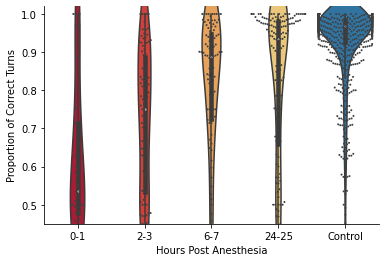

In [9]:
data = OMR_Runs

data = data[(data.Condition == 'wt') | (data.Condition == 'tri_2to6')| (data.Condition == 'tri_2to6_2hr')| (data.Condition == 'tri_2to6_6hr')| (data.Condition == 'tri_2to5')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'tri_2to6', value = '0-1',  inplace = True)
data.replace(to_replace = 'tri_2to6_2hr', value = '2-3',  inplace = True)
data.replace(to_replace = 'tri_2to6_6hr', value = '6-7',  inplace = True)
data.replace(to_replace = 'tri_2to5', value = '24-25',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)
#ColorDict = {'24-25':sns.color_palette("Set2")[4],'0-1': sns.color_palette("Set2")[1],'2-3': sns.color_palette("Set2")[0],'6-7': sns.color_palette("Set2")[3], 'Control': sns.color_palette()[0]}
ColorDict = {'24-25':sns.color_palette("YlOrRd_r")[4],'0-1': sns.color_palette("YlOrRd_r")[0],'2-3': sns.color_palette("YlOrRd_r")[1],'6-7': sns.color_palette("YlOrRd_r")[3], 'Control': sns.color_palette()[0]}
#ColorDict = {'24-25':sns.color_palette("light:salmon")[4],'0-1': sns.color_palette("light:salmon")[0],'2-3': sns.color_palette("light:salmon")[1],'6-7': sns.color_palette("light:salmon")[3], 'Control': sns.color_palette()[0]}

ax = sns.boxplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, fliersize=0, whis = 0,palette = ColorDict, order = ['0-1', '2-3','6-7','24-25','Control'])
#sns.barplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, order = ['Silenced', '2 Hours','6 Hours','24 Hours','Control'])

sns.swarmplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, size = 2, color='.25', order = ['0-1', '2-3','6-7','24-25','Control'])
ax.set(ylim= [0.45, 1.02], xlabel = 'Hours Post Anesthesia', ylabel = 'Proportion of Correct Turns')
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.savefig('Figures/Figure2/CanFishTurn.pdf',bbox_inches='tight')  
# plt.subplot(1,2,2)
# Rights = data[(data.Stimulus == 'Right')]
# Rights['CorrectTurn'] = Rights.OrientationChange>15;
# Rights['AllTurns'] = np.abs(Rights.OrientationChange)>15;
# Corrects = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
# Corrects = Corrects.rename(columns={0: 'CorrectTurn'})
# sns.violinplot(x = 'Condition',y = 'CorrectTurn', data = Corrects)

In [12]:
data = OMR_Runs
data = data[(data.Condition == 'wt') | (data.Condition == 'tri_2to6')| (data.Condition == 'tri_2to6_2hr')| (data.Condition == 'tri_2to6_6hr')| (data.Condition == 'tri_2to5')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'tri_2to6', value = '0-1',  inplace = True)
data.replace(to_replace = 'tri_2to6_2hr', value = '2-3',  inplace = True)
data.replace(to_replace = 'tri_2to6_6hr', value = '6-7',  inplace = True)
data.replace(to_replace = 'tri_2to5', value = '24-25',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)



/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3552515469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3552515469.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/3552515469.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [17]:
Corrects.to_csv("HoursPostAnesthesia.csv")  

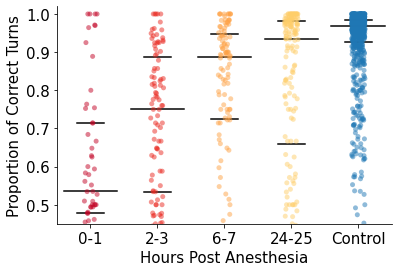

In [44]:
data = OMR_Runs

data = data[(data.Condition == 'wt') | (data.Condition == 'tri_2to6')| (data.Condition == 'tri_2to6_2hr')| (data.Condition == 'tri_2to6_6hr')| (data.Condition == 'tri_2to5')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'tri_2to6', value = '0-1',  inplace = True)
data.replace(to_replace = 'tri_2to6_2hr', value = '2-3',  inplace = True)
data.replace(to_replace = 'tri_2to6_6hr', value = '6-7',  inplace = True)
data.replace(to_replace = 'tri_2to5', value = '24-25',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)
#ColorDict = {'24-25':sns.color_palette("Set2")[4],'0-1': sns.color_palette("Set2")[1],'2-3': sns.color_palette("Set2")[0],'6-7': sns.color_palette("Set2")[3], 'Control': sns.color_palette()[0]}
ColorDict = {'24-25':sns.color_palette("YlOrRd_r")[4],'0-1': sns.color_palette("YlOrRd_r")[0],'2-3': sns.color_palette("YlOrRd_r")[1],'6-7': sns.color_palette("YlOrRd_r")[3], 'Control': sns.color_palette()[0]}
#ColorDict = {'24-25':sns.color_palette("light:salmon")[4],'0-1': sns.color_palette("light:salmon")[0],'2-3': sns.color_palette("light:salmon")[1],'6-7': sns.color_palette("light:salmon")[3], 'Control': sns.color_palette()[0]}

ax = sns.boxplot(x = 'Condition',y = 'CorrectTurn', showbox = False, data = Corrects, fliersize=0, whis = 0,color = 'k', order = ['0-1', '2-3','6-7','24-25','Control'])
#sns.barplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, order = ['Silenced', '2 Hours','6 Hours','24 Hours','Control'])

ax = sns.stripplot(x = 'Condition',y = 'CorrectTurn', alpha=.5, data = Corrects,  palette = ColorDict, order = ['0-1', '2-3','6-7','24-25','Control'])



ax.set(ylim= [0.45, 1.02], xlabel = 'Hours Post Anesthesia', ylabel = 'Proportion of Correct Turns')
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.savefig('Figures/Figure2/CanFishTurn_alt.pdf',bbox_inches='tight')  
# plt.subplot(1,2,2)
# Rights = data[(data.Stimulus == 'Right')]
# Rights['CorrectTurn'] = Rights.OrientationChange>15;
# Rights['AllTurns'] = np.abs(Rights.OrientationChange)>15;
# Corrects = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
# Corrects = Corrects.rename(columns={0: 'CorrectTurn'})
# sns.violinplot(x = 'Condition',y = 'CorrectTurn', data = Corrects)

In [45]:
print(Corrects.groupby('Condition').median())


           CorrectTurn
Condition             
0-1           0.534683
2-3           0.750000
24-25         0.933848
6-7           0.886752
Control       0.967742


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Control


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


2


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


6


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


24


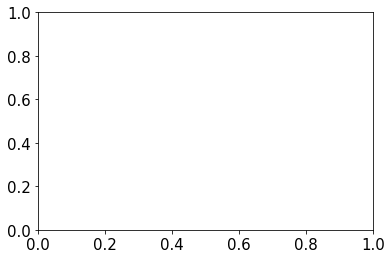

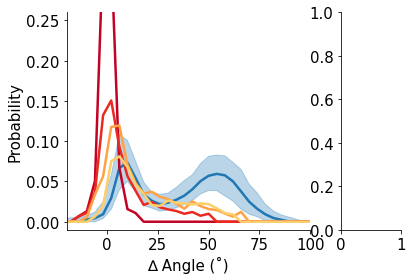

In [60]:
Direction = ['Right']

y_store = []
x_store = []
conditions = []

for curr_cond in ['wt','tri_2to6','tri_2to6_2hr','tri_2to6_6hr','tri_2to5']:
    cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
    IDs= np.unique(cond_subset.FishID)
    for fishid in IDs:
        onefish = cond_subset[cond_subset.FishID == fishid]
        onefish.reset_index(level=0, inplace=True)
        for curr_stim in Direction:
            (x,y) = sns.histplot(data = onefish.query("Stimulus == '"+curr_stim+"'"), x = 'OrientationChange',bins = np.arange(-180,180,360/90), hue = 'Condition', stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = [sns.color_palette()[0]],legend = False).get_lines()[-1].get_data()            
            x_store.extend(x)
            y_store.extend(y)
            conditions.extend([curr_cond]*len(y))
databuff = pd.DataFrame({
        'Probability': y_store,
        'OrientationChange': x_store, 
        'Condition': conditions, 
        })
plt.cla()
f, (ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]})
databuff.replace(to_replace = 'wt', value = 'Control',  inplace = True)
databuff.replace(to_replace = 'tri_2to6', value = '0',  inplace = True)
databuff.replace(to_replace = 'tri_2to6_2hr', value = '2',  inplace = True)
databuff.replace(to_replace = 'tri_2to6_6hr', value = '6',  inplace = True)
databuff.replace(to_replace = 'tri_2to5', value = '24',  inplace = True)
ax = sns.lineplot(x = 'OrientationChange', y = 'Probability',hue = 'Condition', data = databuff)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel = '∆ Angle (˚)')
sns.despine(top=True)
plt.cla()
ColorDict = {'24':sns.color_palette("YlOrRd_r")[4],'0': sns.color_palette("YlOrRd_r")[0],'2': sns.color_palette("YlOrRd_r")[1],'6': sns.color_palette("YlOrRd_r")[3], 'Control': sns.color_palette()[0]}

#ColorDict = {'24':sns.color_palette("Set2")[4],'0': sns.color_palette("Set2")[1],'2': sns.color_palette("Set2")[0],'6': sns.color_palette("Set2")[3], 'Control': sns.color_palette()[0]}

for condition in ['Control','0','2','6','24']:
    fmri_stats = databuff[databuff.Condition == condition].groupby(['OrientationChange']).describe()

    x = fmri_stats.index
    medians = fmri_stats[('Probability', '50%')]
    medians.name = 'Probability'
    quartiles1 = fmri_stats[('Probability', '25%')]
    quartiles3 = fmri_stats[('Probability', '75%')]

    ax = sns.lineplot(x, medians, color = ColorDict[condition], ax = ax1,linewidth = 2.5)
    print(condition)
    ax.legend(condition) 
    if condition == 'Control':
        ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition]); 
#ax.legend(['Control'],frameon=False,loc = 'upper left')
ax.get_legend().remove()
ax.set(xlabel = '∆ Angle (˚)',xlim = [-20,100], ylim = [-0.01,.26])
sns.despine(top=True, ax = ax1)
#plt.savefig('Figures/Probabilities_Strobe.pdf')  


plt.savefig('Figures/Figure2/Probability_tricained_'+Direction[0]+'.pdf',bbox_inches='tight')  


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Control


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


2


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


6


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


24


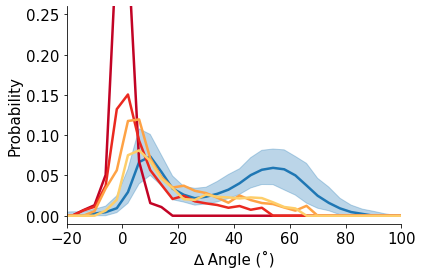

In [104]:
Direction = ['Right']

y_store = []
x_store = []
conditions = []

for curr_cond in ['wt','tri_2to6','tri_2to6_2hr','tri_2to6_6hr','tri_2to5']:
    cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
    IDs= np.unique(cond_subset.FishID)
    for fishid in IDs:
        onefish = cond_subset[cond_subset.FishID == fishid]
        onefish.reset_index(level=0, inplace=True)
        for curr_stim in Direction:
            (x,y) = sns.histplot(data = onefish.query("Stimulus == '"+curr_stim+"'"), x = 'OrientationChange',bins = np.arange(-180,180,360/90), hue = 'Condition', stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = [sns.color_palette()[0]],legend = False).get_lines()[-1].get_data()            
            x_store.extend(x)
            y_store.extend(y)
            conditions.extend([curr_cond]*len(y))
databuff = pd.DataFrame({
        'Probability': y_store,
        'OrientationChange': x_store, 
        'Condition': conditions, 
        })
plt.cla()
databuff.replace(to_replace = 'wt', value = 'Control',  inplace = True)
databuff.replace(to_replace = 'tri_2to6', value = '0',  inplace = True)
databuff.replace(to_replace = 'tri_2to6_2hr', value = '2',  inplace = True)
databuff.replace(to_replace = 'tri_2to6_6hr', value = '6',  inplace = True)
databuff.replace(to_replace = 'tri_2to5', value = '24',  inplace = True)
ax = sns.lineplot(x = 'OrientationChange', y = 'Probability',hue = 'Condition', data = databuff)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel = '∆ Angle (˚)')
sns.despine(top=True)
plt.cla()
#ColorDict = {'24':sns.color_palette("Set2")[4],'0': sns.color_palette("Set2")[1],'2': sns.color_palette("Set2")[0],'6': sns.color_palette("Set2")[3], 'Control': sns.color_palette()[0]}
ColorDict = {'24':sns.color_palette("YlOrRd_r")[4],'0': sns.color_palette("YlOrRd_r")[0],'2': sns.color_palette("YlOrRd_r")[1],'6': sns.color_palette("YlOrRd_r")[3], 'Control': sns.color_palette()[0]}

for condition in ['Control','0','2','6','24']:
    fmri_stats = databuff[databuff.Condition == condition].groupby(['OrientationChange']).describe()

    x = fmri_stats.index
    medians = fmri_stats[('Probability', '50%')]
    medians.name = 'Probability'
    quartiles1 = fmri_stats[('Probability', '25%')]
    quartiles3 = fmri_stats[('Probability', '75%')]

    ax = sns.lineplot(x, medians, color = ColorDict[condition],linewidth = 2.5)
    print(condition)
    ax.legend(condition) 
    if condition == 'Control':
        ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition]); 
#ax.legend(['Control'],frameon=False,loc = 'upper left')
ax.get_legend().remove()
ax.set(xlabel = '∆ Angle (˚)',xlim = [-20,100], ylim = [-0.01,.26])
sns.despine(top=True, ax = ax1)
#plt.savefig('Figures/Probabilities_Strobe.pdf')  


plt.savefig('Figures/Figure2/Probability_tricained_'+Direction[0]+'.pdf',bbox_inches='tight')  


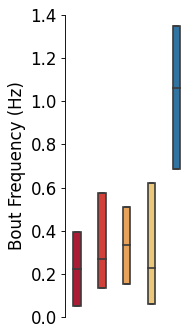

In [105]:
fig = plt.figure(figsize=(2, 5), dpi=80)
data = OMR_Runs.query("Stimulus == '"+Direction[0]+"'")
data = data[(data.Condition == 'tri_2to6')|(data.Condition == 'tri_2to5')|(data.Condition == 'tri_2to6_2hr')|(data.Condition == 'tri_2to6_6hr')| (data.Condition == 'wt')]
z = data.groupby(['FishID','Condition','Age','Date']).count().reset_index()
z['BoutFrequency'] =  z['TrialNum']/300
z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
z.replace(to_replace = 'tri_2to6', value = '0',  inplace = True)
z.replace(to_replace = 'tri_2to6_2hr', value = '2',  inplace = True)
z.replace(to_replace = 'tri_2to6_6hr', value = '6',  inplace = True)
z.replace(to_replace = 'tri_2to5', value = '24',  inplace = True)

ax3 = sns.boxplot(x = 'Condition',y = 'BoutFrequency', data = z,palette = ColorDict, width = 0.3, order = ['0', '2','6','24','Control'], whis = 0, fliersize = 0)
ax3.set(xticklabels=[],xlabel = '',ylabel = 'Bout Frequency (Hz)', xticks = [], ylim = [0,1.4])
for bounds in ['right','top','bottom']:
    right_side = ax3.spines[bounds]
    right_side.set_visible(False)
    right_side = ax2.spines[bounds]
    right_side.set_visible(False)
f.tight_layout()
plt.savefig('Figures/Figure2/BoutsHoursPost.pdf',bbox_inches='tight')  

2 2+3 , pval: 0.3816570677800417
2 2-6 , pval: 7.76070536193463e-11
2 3 , pval: 0.0022876457946879383
2 3+4 , pval: 0.09236691786889985
2 4 , pval: 0.33696244242000706
2 4+5 , pval: 0.0009281012138255881
2 5 , pval: 0.10848213267505259
2 Control , pval: 0.4094588286507681
2+3 2-6 , pval: 3.3630244861164897e-10
2+3 3 , pval: 0.02507028976173395
2+3 3+4 , pval: 0.01072294162959466
2+3 4 , pval: 0.8757281125704306
2+3 4+5 , pval: 0.05655910746067114
2+3 5 , pval: 0.8454015594738507
2+3 Control , pval: 0.004756944314604659
2-6 3 , pval: 4.460584827951272e-05
2-6 3+4 , pval: 9.915772117162913e-15
2-6 4 , pval: 2.142429716524013e-10
2-6 4+5 , pval: 7.246725450073027e-07
2-6 5 , pval: 2.1364385924069127e-12
2-6 Control , pval: 9.093882932241347e-28
3 3+4 , pval: 1.5830692846146062e-06
3 4 , pval: 0.021211736424287145
3 4+5 , pval: 0.9414826354646735
3 5 , pval: 0.0206847741712921
3 Control , pval: 1.1559955212689756e-07
3+4 4 , pval: 0.00509458021511482
3+4 4+5 , pval: 2.1537254771603798e-07


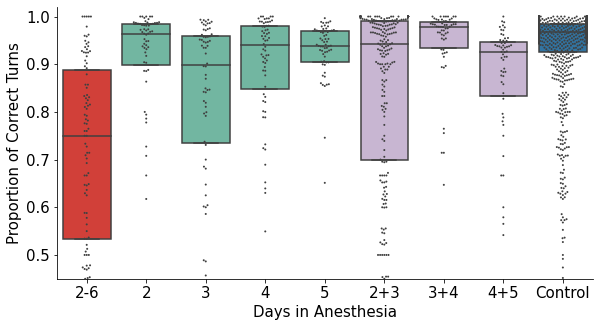

In [46]:
data = OMR_Runs
fig = plt.figure(figsize=(9.6, 5))

data = data[(data.Condition == 'wt')| (data.Condition == 'tri_2to6_2hr') | (data.Condition == 'tri_2to3')| (data.Condition == 'tri_3to4')| (data.Condition == 'tri_4to5')| (data.Condition == 'tri_5to6')| (data.Condition == 'tri_2to4')| (data.Condition == 'tri_3to5')| (data.Condition == 'tri_4to6')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'tri_2to6_2hr', value = '2-6',  inplace = True)
data.replace(to_replace = 'tri_2to3', value = '2',  inplace = True)
data.replace(to_replace = 'tri_3to4', value = '3',  inplace = True)
data.replace(to_replace = 'tri_4to5', value = '4',  inplace = True)
data.replace(to_replace = 'tri_5to6', value = '5',  inplace = True)
data.replace(to_replace = 'tri_2to4', value = '2+3',  inplace = True)
data.replace(to_replace = 'tri_3to5', value = '3+4',  inplace = True)
data.replace(to_replace = 'tri_4to6', value = '4+5',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)
#sns.color_palette("YlOrBr_r")[1]
#ColorDict = {'2-6':sns.color_palette("Set2")[0],'2+3':sns.color_palette('Paired')[8],'3+4': sns.color_palette('Paired')[8],'4+5': sns.color_palette('Paired')[8],'2':sns.color_palette('Paired')[6],'3': sns.color_palette('Paired')[6],'4': sns.color_palette('Paired')[6],'5': sns.color_palette('Paired')[6], 'Control': sns.color_palette()[0]}
ColorDict = {'2-6':sns.color_palette("YlOrRd_r")[1],'2+3':sns.color_palette('Paired')[8],'3+4': sns.color_palette('Paired')[8],'4+5': sns.color_palette('Paired')[8],'2':sns.color_palette("Set2")[0],'3': sns.color_palette("Set2")[0],'4': sns.color_palette("Set2")[0],'5': sns.color_palette("Set2")[0], 'Control': sns.color_palette()[0]}

ax = sns.boxplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, fliersize=0, whis = 0,palette = ColorDict, order = ['2-6','2', '3','4','5','2+3','3+4','4+5','Control'])
#sns.barplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, order = ['Silenced', '2 Hours','6 Hours','24 Hours','Control'])

sns.swarmplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, size = 2, color='.25', order =  ['2-6','2', '3','4','5','2+3','3+4','4+5','Control'])
ax.set(ylim= [0.45, 1.02], xlabel = 'Days in Anesthesia', ylabel = 'Proportion of Correct Turns')

for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.rcParams.update({'font.size': 15})

plt.savefig('Figures/Figure2/MultiDayTurning.pdf',bbox_inches='tight')  

conditions = list(np.unique(Corrects['Condition']))
for type1 in range(len(conditions)):
    for type2 in range(type1+1,len(conditions)):
        print(conditions[type1], conditions[type2], ', pval:',  stats.mannwhitneyu(Corrects['CorrectTurn'][Corrects['Condition']==conditions[type1]],Corrects['CorrectTurn'][Corrects['Condition']==conditions[type2]])[1])

#plt.savefig('Figures/Figure2/CanFishTurn.pdf')  
# plt.subplot(1,2,2)
# Rights = data[(data.Stimulus == 'Right')]
# Rights['CorrectTurn'] = Rights.OrientationChange>15;
# Rights['AllTurns'] = np.abs(Rights.OrientationChange)>15;
# Corrects = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
# Corrects = Corrects.rename(columns={0: 'CorrectTurn'})
# sns.violinplot(x = 'Condition',y = 'CorrectTurn', data = Corrects)

In [47]:
print(Corrects.groupby('Condition').median())


           CorrectTurn
Condition             
2             0.964311
2+3           0.941748
2-6           0.750000
3             0.898660
3+4           0.978258
4             0.939487
4+5           0.925287
5             0.938728
Control       0.967742


In [18]:
data = OMR_Runs

data = data[(data.Condition == 'wt')| (data.Condition == 'tri_2to6_2hr') | (data.Condition == 'tri_2to3')| (data.Condition == 'tri_3to4')| (data.Condition == 'tri_4to5')| (data.Condition == 'tri_5to6')| (data.Condition == 'tri_2to4')| (data.Condition == 'tri_3to5')| (data.Condition == 'tri_4to6')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'tri_2to6_2hr', value = '2-6',  inplace = True)
data.replace(to_replace = 'tri_2to3', value = '2',  inplace = True)
data.replace(to_replace = 'tri_3to4', value = '3',  inplace = True)
data.replace(to_replace = 'tri_4to5', value = '4',  inplace = True)
data.replace(to_replace = 'tri_5to6', value = '5',  inplace = True)
data.replace(to_replace = 'tri_2to4', value = '2+3',  inplace = True)
data.replace(to_replace = 'tri_3to5', value = '3+4',  inplace = True)
data.replace(to_replace = 'tri_4to6', value = '4+5',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)



/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/2681558960.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/2681558960.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_23939/2681558960.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [20]:
Corrects.to_csv("DayAnesthesia.csv")

In [29]:
data = OMR_Runs

data = data[(data.Condition == 'tri_2to5')| (data.Condition == 'tri_3to6_2hr')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'tri_2to5', value = '2to5',  inplace = True)
data.replace(to_replace = 'tri_3to6_2hr', value = '3to6',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)



In [31]:
Corrects

,FishID,Condition,CorrectTurn
0,2021-03-24_11-29-35_589,2to5,0.606061
1,2021-03-24_11-29-35_591,2to5,0.520000
2,2021-03-24_11-30-54_784,2to5,0.230769
3,2021-03-24_11-30-54_785,2to5,0.500000
4,2021-03-24_11-30-54_786,2to5,0.333333
...,...,...,...
126,2022-08-17_14-30-55_312,3to6,0.734694
127,2022-08-17_14-31-30_213,3to6,0.763393
128,2022-08-17_14-31-30_214,3to6,0.970803
129,2022-08-17_14-31-30_215,3to6,1.000000


In [40]:
Corrects[Corrects['Condition']=='3to6']['CorrectTurn'].median()

0.8647058823529412

In [41]:
Corrects[Corrects['Condition']=='2to5']['CorrectTurn'].median()

0.9338481338481339

In [42]:
Corrects['CorrectTurn'].median()

0.9035087719298246

In [30]:
Corrects.to_csv("3DayAnesthesia.csv")

/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Control
2to6


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


3to4


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


2to4


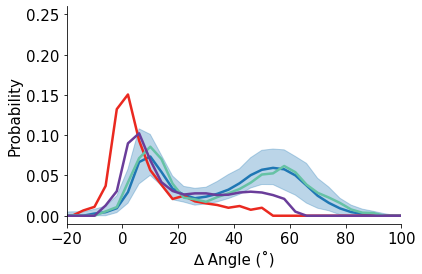

In [101]:
Direction = ['Right']

y_store = []
x_store = []
conditions = []

databuff = pd.DataFrame(columns=['OrientationChange','Condition','Count'])
for curr_cond in ['wt','tri_2to6_2hr','tri_2to3','tri_2to4']:
    cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
    IDs= np.unique(cond_subset.FishID)
    for fishid in IDs:
        onefish = cond_subset[cond_subset.FishID == fishid]
        onefish.reset_index(level=0, inplace=True)
        for curr_stim in Direction:
            (x,y) = sns.histplot(data = onefish.query("Stimulus == '"+curr_stim+"'"), x = 'OrientationChange',bins = np.arange(-180,180,360/90), hue = 'Condition', stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = [sns.color_palette()[0]],legend = False).get_lines()[-1].get_data()            
            x_store.extend(x)
            y_store.extend(y)
            conditions.extend([curr_cond]*len(y))
databuff = pd.DataFrame({
        'Probability': y_store,
        'OrientationChange': x_store, 
        'Condition': conditions, 
        })
plt.cla()
databuff.replace(to_replace = 'wt', value = 'Control',  inplace = True)
databuff.replace(to_replace = 'tri_2to6_2hr', value = '2to6',  inplace = True)
databuff.replace(to_replace = 'tri_2to3', value = '3to4',  inplace = True)
databuff.replace(to_replace = 'tri_2to4', value = '2to4',  inplace = True)
ax = sns.lineplot(x = 'OrientationChange', y = 'Probability',hue = 'Condition', data = databuff)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel = '∆ Angle (˚)')
sns.despine(top=True)
plt.cla()
#ColorDict = {'2to4':sns.color_palette('Paired')[8],'2to6': sns.color_palette('Set2')[4],'3to4': sns.color_palette('Paired')[6], 'Control': sns.color_palette()[0]}
ColorDict = {'2to4':sns.color_palette('Paired')[9],'2to6': sns.color_palette("YlOrRd_r")[1],'3to4': sns.color_palette("Set2")[0], 'Control': sns.color_palette()[0]}

for condition in ['Control','2to6','3to4','2to4']:
    fmri_stats = databuff[databuff.Condition == condition].groupby(['OrientationChange']).describe()

    x = fmri_stats.index
    medians = fmri_stats[('Probability', '50%')]
    medians.name = 'Probability'
    quartiles1 = fmri_stats[('Probability', '25%')]
    quartiles3 = fmri_stats[('Probability', '75%')]

    ax = sns.lineplot(x, medians, color = ColorDict[condition],linewidth = 2.5)
    print(condition)
    ax.legend(condition) 
    if condition == 'Control':
        ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition]); 

#ax.legend(['Control'],frameon=False,loc = 'upper left')
ax.get_legend().remove()
ax.set(xlabel = '∆ Angle (˚)',xlim = [-20,100], ylim = [-0.01,.26])
sns.despine(top=True, ax = ax1)

plt.savefig('Figures/Figure2/Probability_multitricained_'+Direction[0]+'.pdf',bbox_inches='tight')  

#sns.despine(top=True, left = True,right = False, bottom = True, ax = ax3)
#sns.despine(top=True, left = True,right = True, bottom = True, ax = ax2)




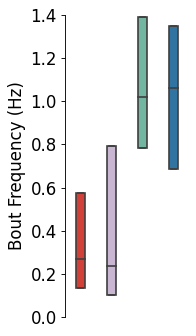

In [103]:
fig = plt.figure(figsize=(2, 5), dpi=80)
data = OMR_Runs.query("Stimulus == '"+Direction[0]+"'")
data = data[(data.Condition == 'tri_2to4')|(data.Condition == 'tri_3to4')|(data.Condition == 'tri_2to6_2hr')| (data.Condition == 'wt')]
z = data.groupby(['FishID','Condition','Age','Date']).count().reset_index()
z['BoutFrequency'] =  z['TrialNum']/300
z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
z.replace(to_replace = 'tri_2to6_2hr', value = '2to6',  inplace = True)
z.replace(to_replace = 'tri_2to4', value = '2to4',  inplace = True)
z.replace(to_replace = 'tri_3to4', value = '3to4',  inplace = True)
ColorDict = {'2to4':sns.color_palette('Paired')[8],'2to6': sns.color_palette("YlOrRd_r")[1],'3to4': sns.color_palette("Set2")[0], 'Control': sns.color_palette()[0]}

ax3 = sns.boxplot(x = 'Condition',y = 'BoutFrequency', data = z,palette = ColorDict, width = 0.3, order = ['2to6','2to4','3to4', 'Control'], whis = 0, fliersize = 0)
ax3.set(xticklabels=[],xlabel = '',ylabel = 'Bout Frequency (Hz)', xticks = [], ylim = [0,1.4])
for bounds in ['right','top','bottom']:
    right_side = ax3.spines[bounds]
    right_side.set_visible(False)
    right_side = ax2.spines[bounds]
    right_side.set_visible(False)
f.tight_layout()
plt.savefig('Figures/Figure2/BoutsDaysPost.pdf',bbox_inches='tight')  

# Behavior under tricaine

In [85]:
ControlRuns = pd.read_pickle("Control_PreTricPost.pkl")

TricRuns = pd.read_pickle("PreTricPost.pkl")
TricRuns['Condition'][TricRuns['Condition'] == 'preTric'] = 'PreTric'
PreTrics_2 = TricRuns[TricRuns['Condition'] == 'PreTric']['FishID'].unique()
Tric_2 = TricRuns[TricRuns['Condition'] == 'Tric']['FishID'].unique()
PostTric1_2 = TricRuns[TricRuns['Condition'] == 'PostTric1']['FishID'].unique()
#PostTric2_2 = TricRuns[TricRuns['Condition'] == 'PostTric2']['FishID'].unique()

PreTrics = ControlRuns[ControlRuns['Condition'] == 'WT_Hour1']['FishID'].unique()
Tric = ControlRuns[ControlRuns['Condition'] == 'WT_Hour2']['FishID'].unique()
PostTric1 = ControlRuns[ControlRuns['Condition'] == 'WT_Hour3']['FishID'].unique()
#PostTric2 = ControlRuns[ControlRuns['Condition'] == 'WT_Hour4']['FishID'].unique()

ControlData = {}

for fishNums in range(len(PreTrics)):
    EmptyList = []
    EmptyList = EmptyList + list(ControlRuns[ControlRuns['FishID'] == PreTrics[fishNums]].BoutTime/60)
    EmptyList = EmptyList + list(ControlRuns[ControlRuns['FishID'] == Tric[fishNums]].BoutTime/60+50)
    EmptyList = EmptyList + list(ControlRuns[ControlRuns['FishID'] == PostTric1[fishNums]].BoutTime/60+100)
    #EmptyList = EmptyList + list(ControlRuns[ControlRuns['FishID'] == PostTric2[fishNums]].BoutTime/60+150)
    ControlData['Fish'+str(fishNums)] = EmptyList

TricaineData = {}
for fishNums2 in range(len(PreTrics_2)):
    fishNums = fishNums+1
    ControlData['Fish'+str(fishNums)] = list(TricRuns[TricRuns['FishID'] == PreTrics_2[fishNums2]].BoutTime/60)
    
    EmptyList = []
    EmptyList = EmptyList + list(TricRuns[TricRuns['FishID'] == PreTrics_2[fishNums2]].BoutTime/60)
    EmptyList = EmptyList + list(TricRuns[TricRuns['FishID'] == Tric_2[fishNums2]].BoutTime/60+50)
    EmptyList = EmptyList + list(TricRuns[TricRuns['FishID'] == PostTric1_2[fishNums2]].BoutTime/60+100)
    #EmptyList = EmptyList + list(TricRuns[TricRuns['FishID'] == PostTric2_2[fishNums2]].BoutTime/60+150)
    TricaineData['Fish'+str(fishNums2)] = EmptyList

LifetimeRuns = pd.read_pickle("Lifetime_PreTricPost.pkl")
Lifetime = LifetimeRuns[LifetimeRuns['Condition'] == 'lifetime_tric']['FishID'].unique()
PostLife1 = LifetimeRuns[LifetimeRuns['Condition'] == 'lifetime_wash1']['FishID'].unique()
#PostLife2 = LifetimeRuns[LifetimeRuns['Condition'] == 'lifetime_wash2']['FishID'].unique()

LifetimeData = {}

for fishNums in range(len(PostLife1)):
    EmptyList = []
    if (np.where([str(int(PostLife1[fishNums].split('_')[-1])-4) in i for i in Lifetime])[0]).size > 0:
        EmptyList = EmptyList + list(LifetimeRuns[LifetimeRuns['FishID'] == Lifetime[(np.where([str(int(PostLife1[fishNums].split('_')[-1])-4) in i for i in Lifetime])[0])[0]]].BoutTime/60+50)
    EmptyList = EmptyList + list(LifetimeRuns[LifetimeRuns['FishID'] == PostLife1[fishNums]].BoutTime/60+100)
    #EmptyList = EmptyList + list(LifetimeRuns[LifetimeRuns['FishID'] == PostLife2[fishNums]].BoutTime/60+150)
    LifetimeData['Fish'+str(fishNums)] = EmptyList
    

/var/folders/lz/cvvv4_05045_3y2lylrlxf5w0000gn/T/ipykernel_1956/4149904196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TricRuns['Condition'][TricRuns['Condition'] == 'preTric'] = 'PreTric'


16


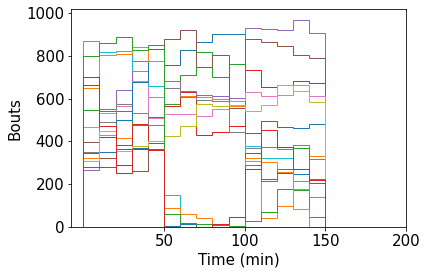

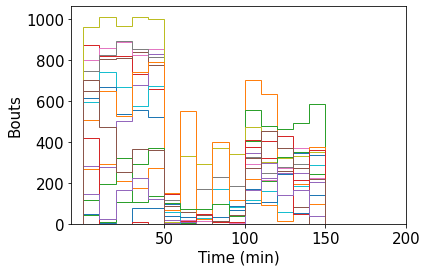

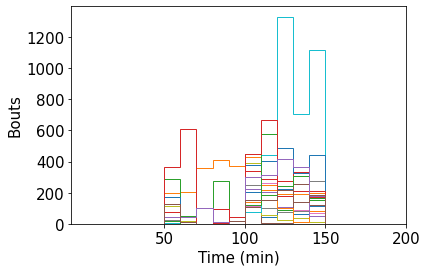

In [89]:
GoodFish = [0,1,2,3,7,13,15,16,17]
max_val = 15 #20
x_storer = np.empty((0,max_val), int)
n_storer = np.empty((0,max_val+1), int)
for fishies in GoodFish:
    x,n,_ = plt.hist(ControlData['Fish'+str(fishies)],bins = range(0,(max_val+1)*10,10),histtype=u'step')
    x_storer = np.append(x_storer,np.expand_dims(np.array(x),axis=0),axis = 0)
    n_storer = np.append(n_storer,np.expand_dims(np.array(n),axis=0),axis = 0)

GoodFish = [3,4,5,6,15]
for fishies in GoodFish:
    x,n,_ = plt.hist(TricaineData['Fish'+str(fishies)],bins = range(0,(max_val+1)*10,10),histtype=u'step')
    x[5:] = np.nan
    x_storer = np.append(x_storer,np.expand_dims(np.array(x),axis=0),axis = 0)
    n_storer = np.append(n_storer,np.expand_dims(np.array(n),axis=0),axis = 0)
plt.xticks([50,100,150,200])
plt.xlabel('Time (min)')
plt.ylabel('Bouts')

plt.figure()
#GoodFish = [3,4,5,6,14,15]
GoodFish = list(range(16))
#GoodFish =[2]
x_storer_tric = np.empty((0,max_val), int)
n_storer_tric = np.empty((0,max_val+1), int)
for fishies in GoodFish:
    x,n,_ = plt.hist(TricaineData['Fish'+str(fishies)],bins = range(0,(max_val+1)*10,10),histtype=u'step')
    x_storer_tric = np.append(x_storer_tric,np.expand_dims(np.array(x),axis=0),axis = 0)
    n_storer_tric = np.append(n_storer_tric,np.expand_dims(np.array(n),axis=0),axis = 0)
plt.xticks([50,100,150,200])
plt.xlabel('Time (min)')
plt.ylabel('Bouts')

plt.figure()
GoodFish = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
GoodFish = list(range(16))
x_storer_LT = np.empty((0,max_val), int)
n_storer_LT = np.empty((0,max_val+1), int)
for fishies in GoodFish:
    x,n,_ = plt.hist(LifetimeData['Fish'+str(fishies)],bins = range(0,(max_val+1)*10,10),histtype=u'step')
    x_storer_LT = np.append(x_storer_LT,np.expand_dims(np.array(x),axis=0),axis = 0)
    n_storer_LT = np.append(n_storer_LT,np.expand_dims(np.array(n),axis=0),axis = 0)
plt.xticks([50,100,150,200])
plt.xlabel('Time (min)')
plt.ylabel('Bouts')
print(x_storer_LT.shape[0])

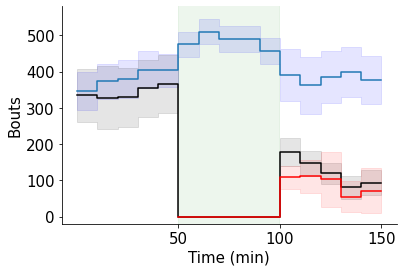

In [100]:
import matplotlib.patches as patches

ax = plt.subplot(1,1,1)
ax.add_patch(patches.Rectangle((50, -500), 49.5, 2000, color = 'g', alpha = 0.07))

y = [max(val-150,0) for val in list(np.nanmean(x_storer,axis=0))+[np.nanmean(x_storer[:,-1])]]
err = np.array(list(np.nanstd(x_storer,axis=0))+[np.nanstd(x_storer[:,-1])])/np.sqrt(x_storer.shape[0])
#plt.step(x = list(n_storer.mean(axis = 0)), y=y,where = 'post')
plt.step(x = list(np.median(n_storer,axis =0)), y=y,where = 'post')
ax.fill_between(list(n_storer.mean(axis = 0)), y-err, y+err, step='post', color='b', alpha=0.1)

y = [max(val-150,0) for val in list(x_storer_tric.mean(axis=0))+[x_storer_tric[:,-1].mean()]]
err = np.array(list(x_storer_tric.std(axis=0))+[x_storer_tric[:,-1].std()])/np.sqrt(x_storer_tric.shape[0])
plt.step(x = list(n_storer_tric.mean(axis = 0)), y=y,where = 'post',color = 'k')
lower = y-err
lower[lower<0] = 0
err[5:10]=0
ax.fill_between(list(n_storer_tric.mean(axis = 0)), lower, y+err, step='post', color='k', alpha=0.1)


y = [max(val-150,0) for val in list(x_storer_LT.mean(axis=0))+[x_storer_LT[:,-1].mean()]]
err = np.array(list(x_storer_LT.std(axis=0))+[x_storer_LT[:,-1].std()])/np.sqrt(x_storer_LT.shape[0])
plt.step(x = list(n_storer_LT.mean(axis = 0))[5:], y=y[5:],where = 'post',color = 'r')
lower = y-err
lower[lower<0] = 0
err[:10]=0
ax.fill_between(list(n_storer_LT.mean(axis = 0))[5:], lower[5:], y[5:]+err[5:], step='post', color='r', alpha=0.1)

for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
plt.xticks([50,100,150])
plt.ylim([-20,580])
plt.xlabel('Time (min)')
plt.ylabel('Bouts')
plt.rcParams.update({'font.size': 15})
plt.savefig('Figures/Figure2/SpotTricaineBehavior.pdf',bbox_inches='tight') 